In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
import astropy as ast
from astropy import stats

import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

import SessionTools.two_photon as st2p

plt.rcParams['pdf.fonttype']=42

%load_ext autoreload
%autoreload 2 


%matplotlib inline

In [13]:
basedir = pathlib.Path('/media/mplitt/SSD_storage/2P_scratch/EL_jGCaMP7b_TBHRNAi')

sess_df = pd.read_csv(basedir / 'sessions.csv')
print(sess_df.columns)
sess_df['fly_id'] = [row['date']+'_'+row['fly'] +'_' + row['gal4_line'] + '_' + row['rnai_line '] for _, row in sess_df.iterrows()]

figfolder = pathlib.Path('/media/mplitt/SSD_storage/fig_scratch/EL_meetings/EL_jGCaMP7b_TBHRNAi/')
figfolder.mkdir(parents=True, exist_ok=True)

sess_df = sess_df.loc[sess_df['usable']==1]
sess_df = sess_df.loc[~((sess_df['closed_loop']==0) & (sess_df['dark']==0))]

Index(['date', 'fly', 'sess', 'fictrac_scan_num', 'closed_loop', 'dark',
       'rnai_line ', 'gal4_line', 'usable', 'fictrac_dat_file', 'notes'],
      dtype='object')


In [14]:
sess_df.iloc[:10]

date   fly             sess  fictrac_scan_num  closed_loop  dark  \
0   08_04_2024  fly1  closed_loop-000               0.0            1     0   
1   08_04_2024  fly1         dark-001               1.0            0     1   
2   08_04_2024  fly1  closed_loop-002               2.0            2     0   
3   08_04_2024  fly1         dark-003               3.0            0     2   
5   08_04_2024  fly2  closed_loop-002               2.0            1     0   
6   08_04_2024  fly2         dark-003               3.0            0     1   
7   08_04_2024  fly2  closed_loop-004               4.0            2     0   
10  10_04_2024  fly1  closed_loop-000               0.0            1     0   
11  10_04_2024  fly1         dark-002               2.0            0     1   
12  10_04_2024  fly1  closed_loop-003               3.0            2     0   

    rnai_line  gal4_line  usable             fictrac_dat_file notes  \
0      control   ELDR009       1  fictrac-20240408_104747.dat   NaN   
1      control   ELDR009       1  fictrac-20240408_104747.dat   NaN   
2      control   ELDR009       1  fictrac-20240408_104747.dat   NaN   
3      control   ELDR009       1  fictrac-20240408_104747.dat   NaN   
5      control   ELDR009       1  fictrac-20240408_120523.dat   NaN   
6      control   ELDR009       1  fictrac-20240408_120523.dat   NaN   
7      control   ELDR009       1  fictrac-20240408_120523.dat   NaN   
10  rnai_67968   ELDR009       1  fictrac-20240410_082054.dat   NaN   
11  rnai_67968   ELDR009       1  fictrac-20240410_082054.dat   NaN   
12  rnai_67968   ELDR009       1  fictrac-20240410_082054.dat   NaN   

                                fly_id  
0      08_04_2024_fly1_ELDR009_control  
1      08_04_2024_fly1_ELDR009_control  
2      08_04_2024_fly1_ELDR009_control  
3      08_04_2024_fly1_ELDR009_control  
5      08_04_2024_fly2_ELDR009_control  
6      08_04_2024_fly2_ELDR009_control  
7      08_04_2024_fly2_ELDR009_control  
10  10_04_2024_fly1_ELDR009_rnai_67968  
11  10_04_2024_fly1_ELDR009_rnai_67968  
12  10_04_2024_fly1_ELDR009_rnai_67968

In [15]:
stats_df = {'fly_id': [],
           'cl': [],
           'rnai': [],
            'dark': [],
           'offset_var':[],
           'offset_var_nomask': []}


for _,row in sess_df.iterrows():
    if row['usable']==1 and row['gal4_line']!='control':
        outdir = pathlib.PurePath( basedir / row['rnai_line '] / row['date'] / row['fly'] / row['sess'] / 'preprocess.pkl')
        
        pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
        dff = pp.calculate_zscored_F('rois', zscore=False, exp_detrend = True)[-1, :, :] -1
        dff = sp.ndimage.gaussian_filter1d(sp.ndimage.gaussian_filter1d(dff, 1, axis=-1),.5,axis=0, mode='wrap')
        
        
        heading = -1*pp.voltage_recording_aligned[' Heading'].to_numpy()
        h_mask = np.abs(heading)>.5
        
        
        x_f,y_f = st2p.utilities.pol2cart(dff ,np.linspace(-np.pi,np.pi,num=dff.shape[0])[:,np.newaxis])
        rho,phi = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))
        
        _,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi-heading))
        
        
        stats_df['fly_id'].append(row['fly_id'])
        stats_df['cl'].append(row['closed_loop'])
        stats_df['dark'].append(row['dark'])
        stats_df['rnai'].append(row['rnai_line '])
        
        
        stats_df['offset_var'].append(sp.stats.circvar(offset[h_mask]))
        stats_df['offset_var_nomask'].append(sp.stats.circvar(offset))

stats_df = pd.DataFrame.from_dict(stats_df)

In [42]:
stats_df_unique = {'fly_id': [],
           'cl': [],
           'rnai': [],
            'dark': [],
           'offset_var':[],
           }

for r, fly in enumerate(fly_ids):
    
    cl_mask = (stats_df['fly_id']==fly)*(stats_df['cl']>1)
    dark_mask = (stats_df['fly_id']==fly)*(stats_df['dark']>=1)
    if (cl_mask.sum()>0) and (dark_mask.sum()>0):
        rnai = stats_df['rnai'].loc[cl_mask]
        cl = stats_df['offset_var'].loc[cl_mask].mean()

        stats_df_unique['fly_id'].append(fly)
        stats_df_unique['cl'].append(1)
        stats_df_unique['rnai'].append(rnai.iloc[0])
        stats_df_unique['dark'].append(0)
        stats_df_unique['offset_var'].append(cl)
    
    
        dark = stats_df['offset_var'].loc[dark_mask].mean()
        stats_df_unique['fly_id'].append(fly)
        stats_df_unique['cl'].append(0)
        stats_df_unique['rnai'].append(rnai.iloc[0])
        stats_df_unique['dark'].append(1)
        stats_df_unique['offset_var'].append(dark)
        
stats_df_unique = pd.DataFrame.from_dict(stats_df_unique)
    

In [43]:
fly_ids = stats_df['fly_id'].unique()

rnai_ids = np.zeros((len(fly_ids),))
for i, fly in enumerate(fly_ids):
    rnaistate = stats_df['rnai'].loc[stats_df['fly_id']==fly].iloc[0]
    if 'control' in rnaistate:
        rnai_ids[i]=0
    elif 'rnai_67968' in rnaistate:
        rnai_ids[i]=1
    elif 'vglut_rnai' in rnaistate:
        rnai_ids[i]=2
    elif 'vacht_rnai' in rnaistate:
        rnai_ids[i]=3
    else:
        rnai_ids[i]=-1

print(fly_ids,rnai_ids)
    

['08_04_2024_fly1_ELDR009_control' '08_04_2024_fly2_ELDR009_control'
 '10_04_2024_fly1_ELDR009_rnai_67968' '08_04_2024_fly3_ELDR009_control'
 '08_04_2024_fly4_ELDR009_control' '09_04_2024_fly1_ELDR009_control'
 '09_04_2024_fly2_ELDR009_control' '11_04_2024_fly1_ELDR009_control'
 '12_04_2024_fly1_ELDR009_control' '12_04_2024_fly2_ELDR009_control'
 '10_04_2024_fly2_ELDR009_rnai_67968' '10_04_2024_fly3_ELDR009_rnai_67968'
 '11_04_2024_fly1_ELDR009_rnai_67968' '11_04_2024_fly2_ELDR009_rnai_67968'
 '11_04_2024_fly3_ELDR009_rnai_67968' '12_04_2024_fly1_ELDR009_rnai_67968'
 '12_04_2024_fly2_ELDR009_rnai_67968' '06_05_2024_fly2_ELDR009_control'
 '08_05_2024_fly1_ELDR009_control' '08_05_2024_fly2_ELDR009_control'
 '08_05_2024_fly1_ELDR009_rnai_67968' '08_05_2024_fly2_ELDR009_rnai_67968'
 '09_05_2024_fly1_ELDR009_rnai_67968' '09_05_2024_fly2_ELDR009_rnai_67968'
 '03_06_2024_fly1_ELDR009_vglut_rnai' '03_06_2024_fly2_ELDR009_vglut_rnai'
 '03_06_2024_fly4_ELDR009_vglut_rnai' '04_06_2024_fly1_ELDR00

ctrl 0.0 0.001953125
tbh 30.0 0.8310546875
ctrl v tbh 1.0 0.00016498530087593564
ctrl v tbh dark 68.0 0.8398599725400034
diff: ctrl v tbh 103.0 0.0008232730367295283
vglut 0.0 0.0009765625
vglut v tbh 121.0 8.151536127743244e-05


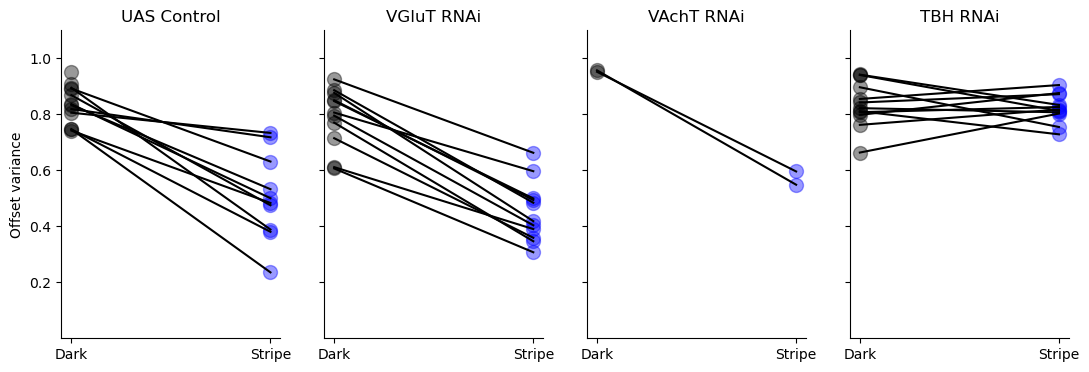

In [44]:
fly_avgs = np.zeros((len(fly_ids),2))
for r, fly in enumerate(fly_ids):
    
    mask = (stats_df['fly_id']==fly)*(stats_df['cl']>1)
    # print(stats_df.loc[mask])
    cl = stats_df['offset_var'].loc[mask].mean()
    fly_avgs[r,0]=cl
    
    mask = (stats_df['fly_id']==fly)*(stats_df['dark']>=1)
    dark = stats_df['offset_var'].loc[mask].mean()
    fly_avgs[r,1] = dark
    

fig,ax = plt.subplots(1,4,sharey=True, figsize=[13,4])

c_h = ax[0].plot([0,1],fly_avgs[rnai_ids==0,::-1].T, color='black')
ax[0].scatter(np.zeros(((rnai_ids==0).sum(),)),fly_avgs[rnai_ids==0,-1], color='black', alpha=.4,s=100)
ax[0].scatter(np.ones(((rnai_ids==0).sum(),)),fly_avgs[rnai_ids==0,0], color='blue', alpha=.4,s=100)


d_h = ax[3].plot([0,1],fly_avgs[rnai_ids==1,::-1].T, color='black')
ax[3].scatter(np.zeros(((rnai_ids==1).sum(),)),fly_avgs[rnai_ids==1,-1], color='black', alpha=.4,s=100)
ax[3].scatter(np.ones(((rnai_ids==1).sum(),)),fly_avgs[rnai_ids==1,0], color='blue', alpha=.4,s=100)

c_h = ax[1].plot([0,1], fly_avgs[rnai_ids==2,::-1].T, color='black')
ax[1].scatter(np.zeros(((rnai_ids==2).sum(),)),fly_avgs[rnai_ids==2,-1], color='black', alpha=.4,s=100)
ax[1].scatter(np.ones(((rnai_ids==2).sum(),)),fly_avgs[rnai_ids==2,0], color='blue', alpha=.4,s=100)

c_h = ax[2].plot([0,1], fly_avgs[rnai_ids==3,::-1].T, color='black')
ax[2].scatter(np.zeros(((rnai_ids==3).sum(),)),fly_avgs[rnai_ids==3,-1], color='black', alpha=.4,s=100)
ax[2].scatter(np.ones(((rnai_ids==3).sum(),)),fly_avgs[rnai_ids==3,0], color='blue', alpha=.4,s=100)


t,p = sp.stats.wilcoxon(fly_avgs[rnai_ids==0,0], fly_avgs[rnai_ids==0,1], nan_policy='omit')
print('ctrl', t,p)

t,p = sp.stats.wilcoxon(fly_avgs[rnai_ids==1,0], fly_avgs[rnai_ids==1,1], nan_policy='omit')
print('tbh', t,p)

t,p = sp.stats.mannwhitneyu(fly_avgs[rnai_ids==0,0], fly_avgs[rnai_ids==1,0], nan_policy='omit')
print('ctrl v tbh',t,p)

t,p = sp.stats.mannwhitneyu(fly_avgs[rnai_ids==0,1], fly_avgs[rnai_ids==1,1], nan_policy='omit')
print('ctrl v tbh dark',t,p)

diff = fly_avgs[:,1]-fly_avgs[:,0]
t,p = sp.stats.mannwhitneyu(diff[rnai_ids==0], diff[rnai_ids==1], nan_policy='omit')
print('diff: ctrl v tbh', t,p)

t,p = sp.stats.wilcoxon(fly_avgs[rnai_ids==2,0], fly_avgs[rnai_ids==2,1], nan_policy='omit')
print('vglut', t,p)

t,p = sp.stats.mannwhitneyu(fly_avgs[rnai_ids==1,0], fly_avgs[rnai_ids==2,0], nan_policy='omit')
print('vglut v tbh', t,p)




for i in range(4):
    ax[i].set_ylim([0.0,1.1])
    ax[i].set_yticks([.2,.4,.6,.8,1.])

    ax[i].set_xticks([0, 1], labels=['Dark', 'Stripe'])
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    
ax[0].set_ylabel('Offset variance')
# ax.legend([c_h[0],d_h[0]], ['control', 'mianserin 50 uM'], loc='lower right')


ax[0].set_title('UAS Control')
ax[3].set_title('TBH RNAi')
ax[1].set_title('VGluT RNAi')
ax[2].set_title('VAchT RNAi')
# for r in range(fly_avgs.shape[0]):
#     print(fly_ids[r], fly_avgs[r,0], fly_avgs[r,1], rnai_ids[r])
fig.savefig(figfolder / 'offset_var_summary.pdf', format='pdf')

In [45]:
stats_df['rnai'].unique()

array(['control', 'rnai_67968', 'vglut_rnai', 'vacht_rnai'], dtype=object)

In [53]:
df = stats_df_unique.loc[stats_df_unique['rnai']!='vacht_rnai']
model = mixedlm('offset_var ~ C(rnai, Treatment("control"))*C(dark, Treatment(1))', df, groups=df['fly_id'])
result = model.fit()
print(result.summary())
print(result.pvalues)

                                      Mixed Linear Model Regression Results
Model:                               MixedLM                    Dependent Variable:                    offset_var
No. Observations:                    64                         Method:                                REML      
No. Groups:                          32                         Scale:                                 0.0060    
Min. group size:                     2                          Log-Likelihood:                        47.0067   
Max. group size:                     2                          Converged:                             Yes       
Mean group size:                     2.0                                                                         
-----------------------------------------------------------------------------------------------------------------
                                                                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------

/home/mplitt/mambaforge/envs/SessionTools/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [54]:
def get_ts(pp, coef = 0):
    y_epg = pp.calculate_zscored_F('rois', zscore=False, exp_detrend = True)
    heading = np.angle(np.exp(1j*(-1*pp.voltage_recording_aligned[' Heading'].to_numpy()-np.pi)))
    bar_vis_mask = np.abs(heading)<2.64
   
    y_epg_sm = sp.ndimage.gaussian_filter1d(sp.ndimage.gaussian_filter1d(y_epg-1, 1, axis=-1),.5,axis=1, mode='wrap')
    
    
    n_rois = y_epg.shape[1]
    x_f,y_f = st2p.utilities.pol2cart(y_epg[-1,:,:] ,np.linspace(-np.pi,np.pi,num=n_rois)[:,np.newaxis])
    rho_epg, phi_epg = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))


    _,offset_epg = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi_epg-heading))

    
    return {'heading': heading,
            'bar_vis_mask': bar_vis_mask,
            'y_epg': y_epg,
            'y_epg_sm': y_epg_sm,
            'rho_epg': rho_epg,
            'phi_epg': phi_epg,
            'offset_epg': offset_epg}


def align_to_heading(ts):
    heading_bins = np.linspace(-np.pi, np.pi, num=17)
    heading_dig = np.digitize(ts['heading'], heading_bins)-1

    y_h_aligned = np.zeros([1,*ts['y_epg'].shape[1:]])
    for ind in range(ts['heading'].shape[0]):
        y_h_aligned[-1,:,ind] = np.roll(ts['y_epg'][-1,:,ind], -heading_dig[ind]-8)
       
       
        
    y_h_aligned_z = np.zeros((1,16,16))
    for b in range(16):
        mask = heading_dig==b
        y_h_aligned_z[:,:,b] = y_h_aligned[:,:,mask].mean(axis=-1)
    
    
    return heading_bins, y_h_aligned, y_h_aligned_z

In [55]:
eg_folder = figfolder / 'example_sessions' 
eg_folder.mkdir(parents=True, exist_ok=True)

/tmp/ipykernel_1738647/3477617001.py:39: RuntimeWarning: Mean of empty slice.
  y_h_aligned_z[:,:,b] = y_h_aligned[:,:,mask].mean(axis=-1)
/home/mplitt/mambaforge/envs/SessionTools/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_1738647/1402746213.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax=plt.subplots(1,2, figsize=[30,3])


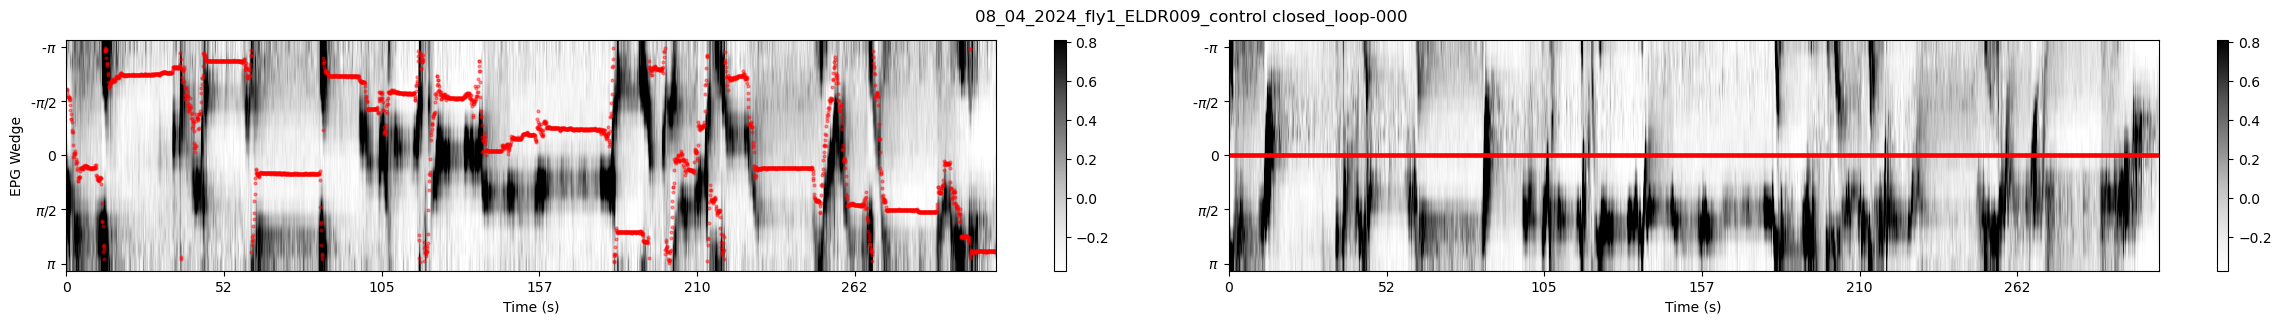

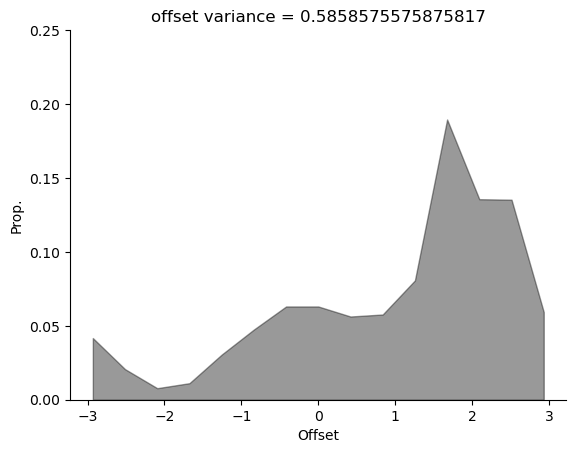

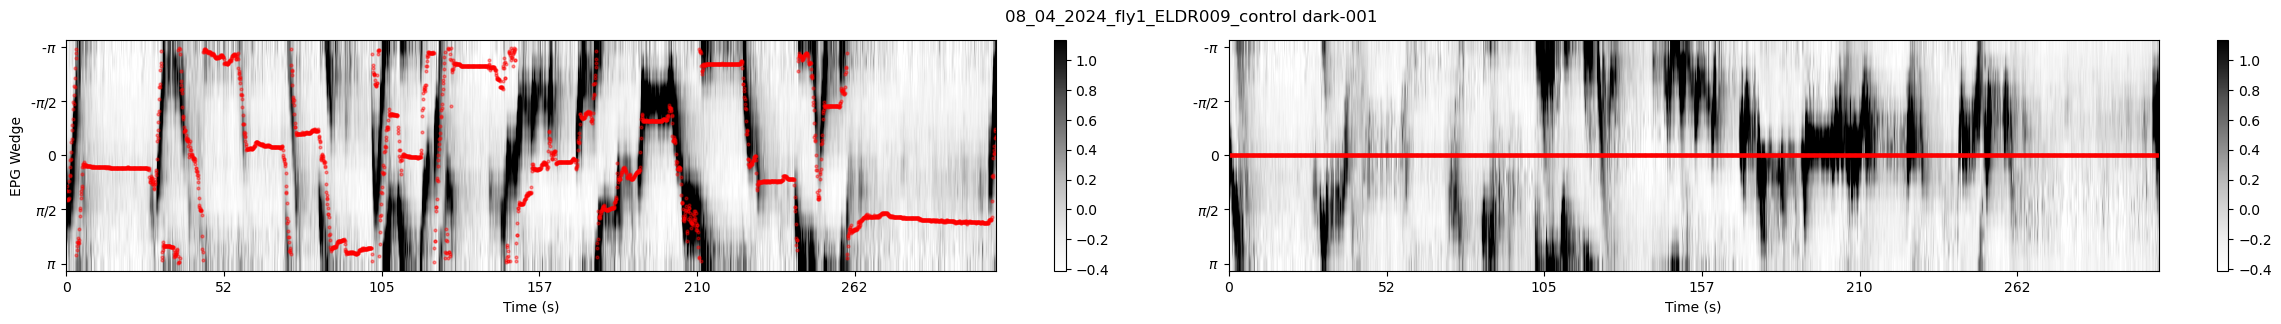

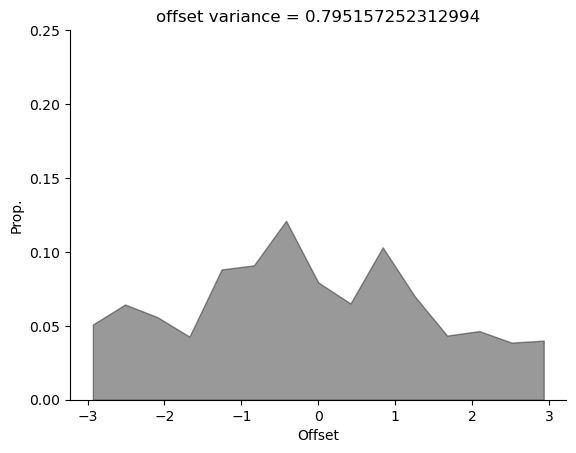

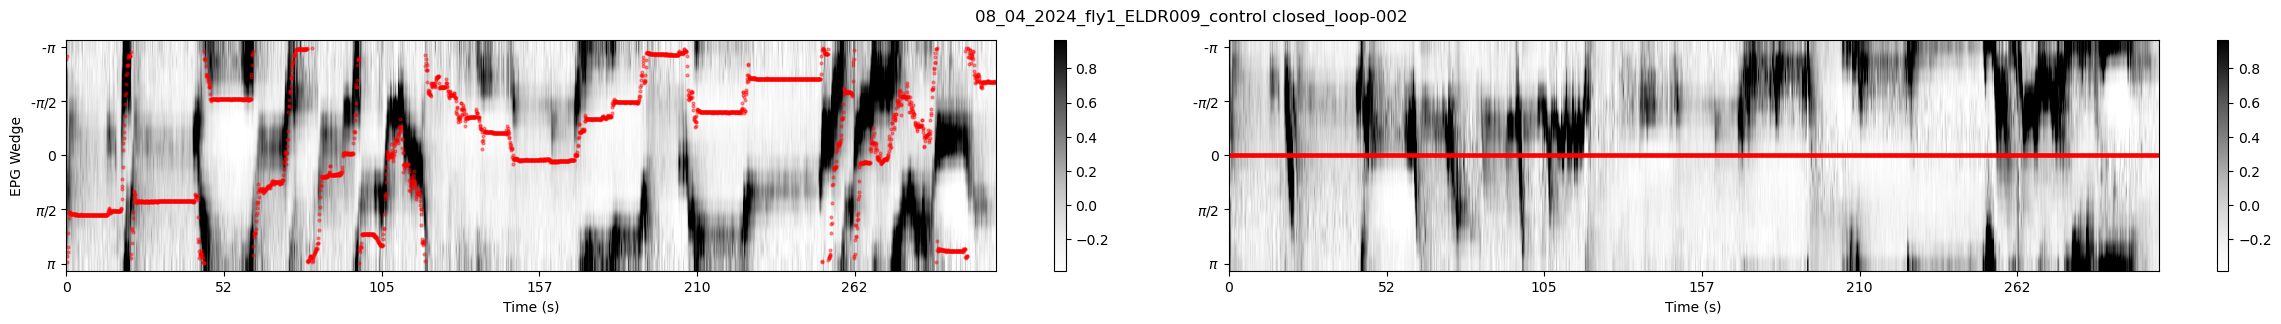

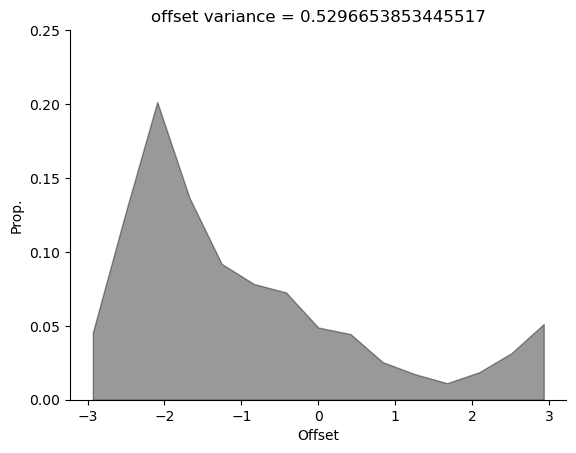

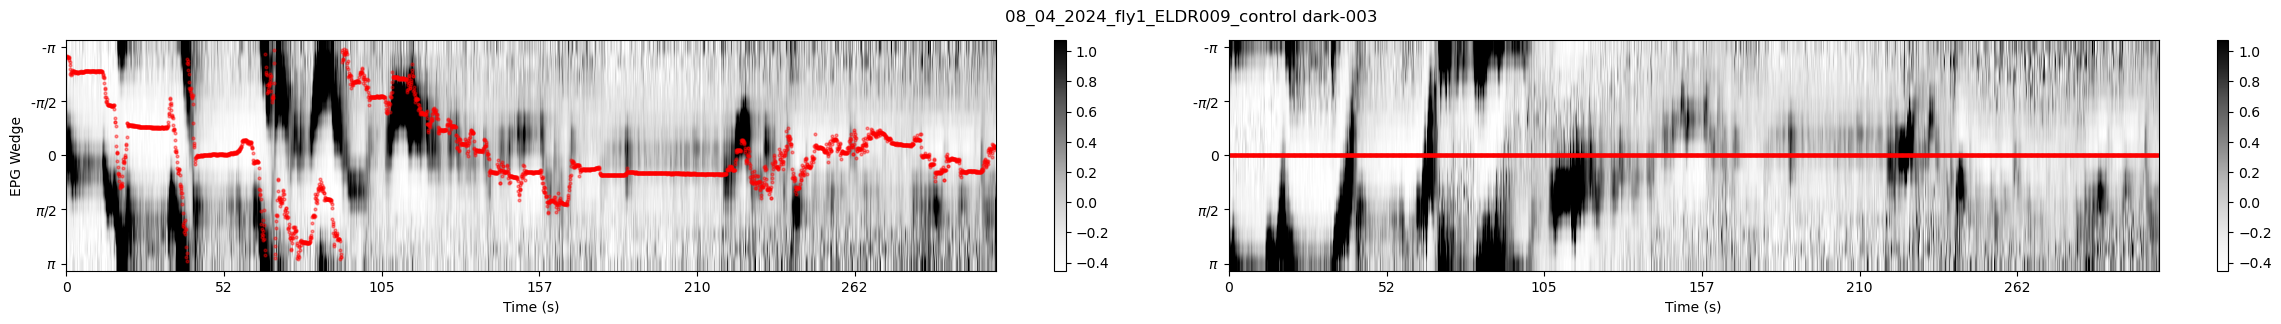

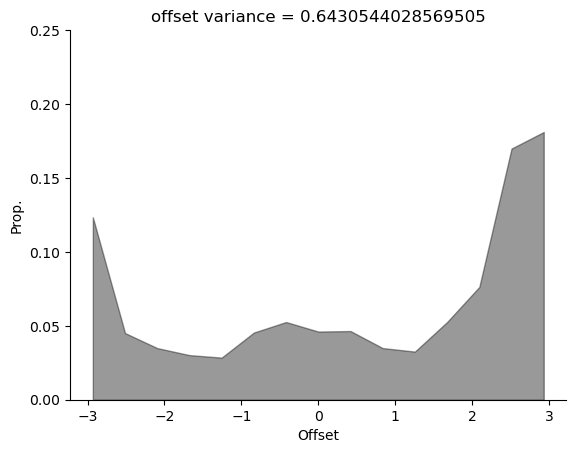

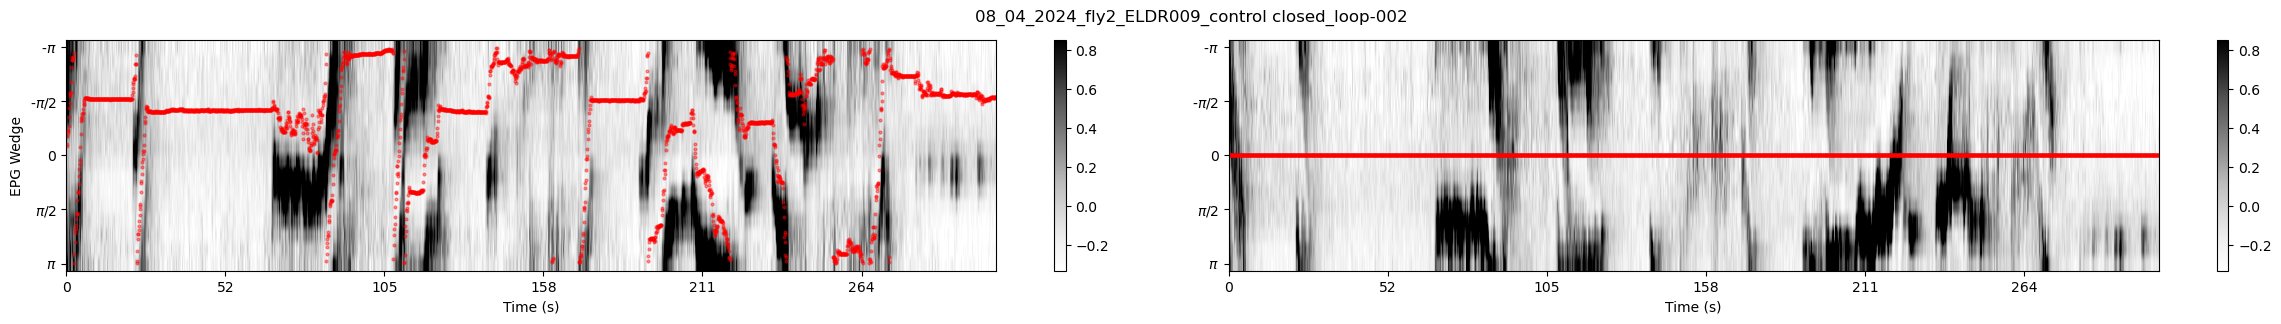

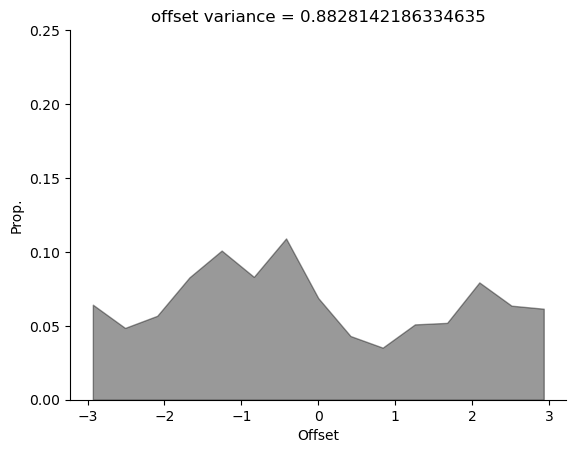

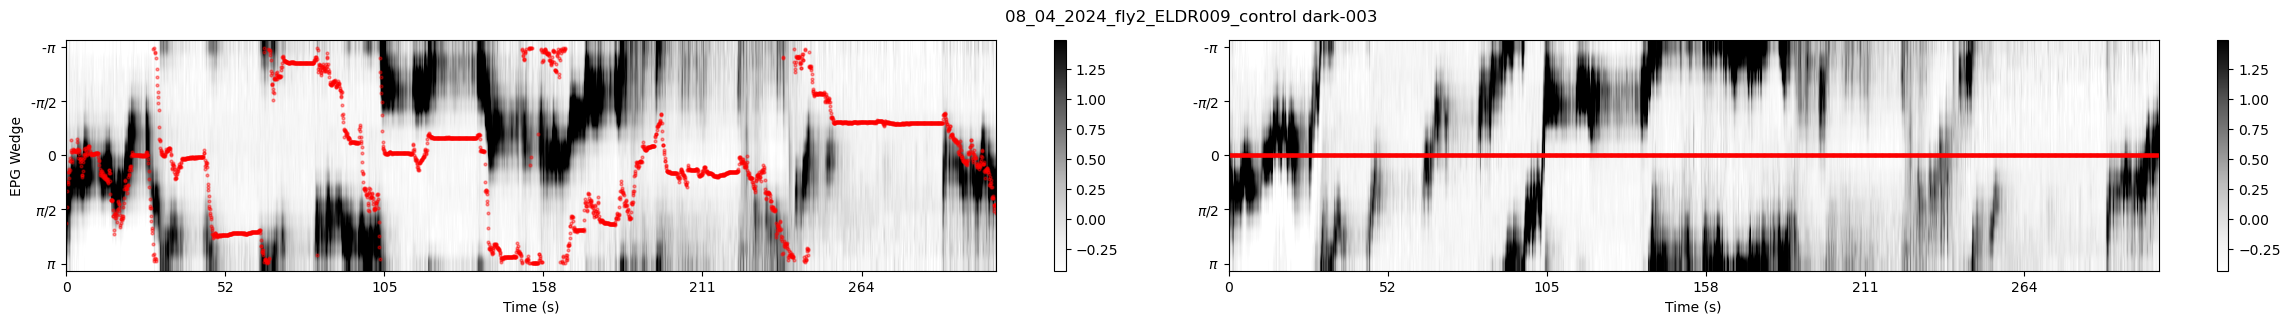

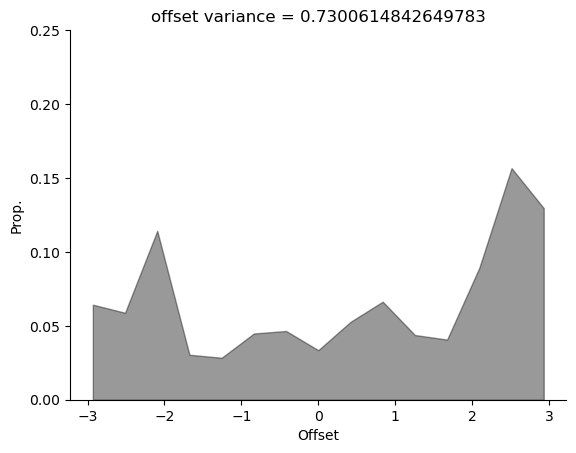

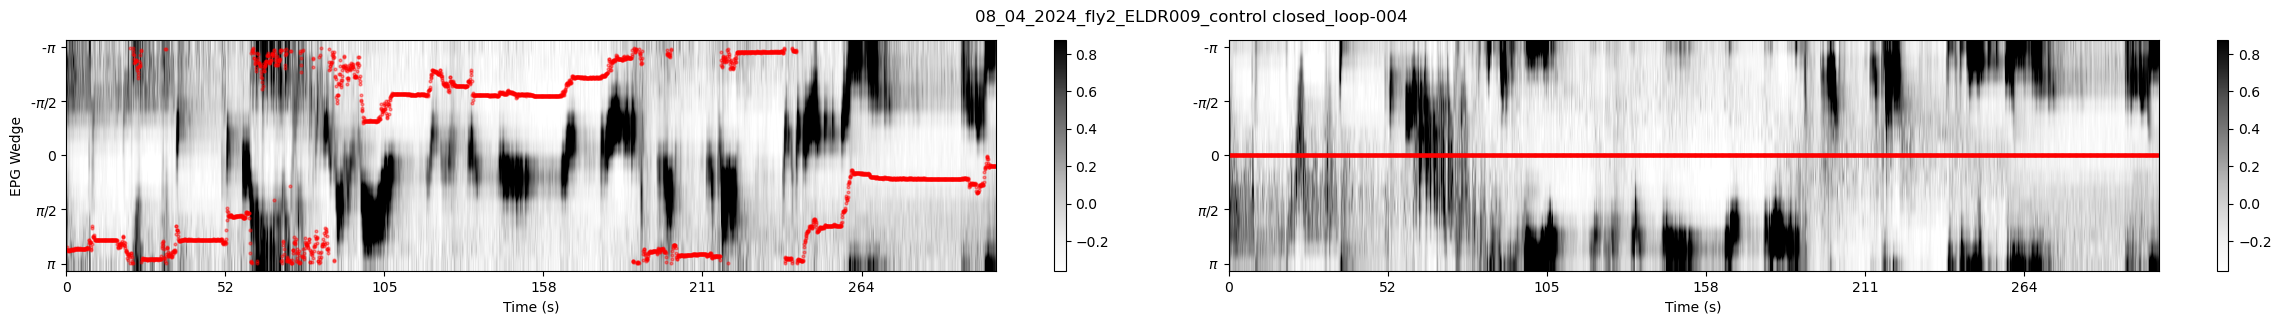

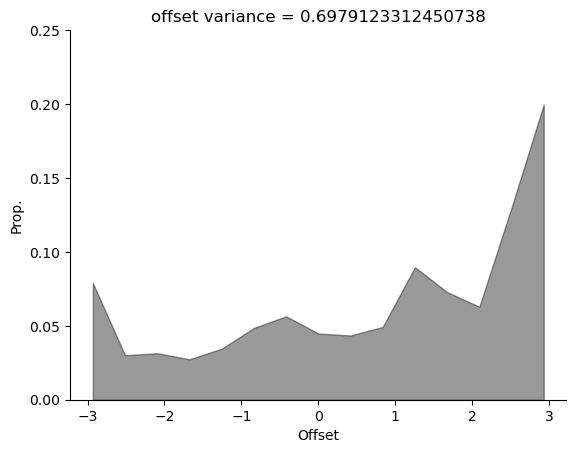

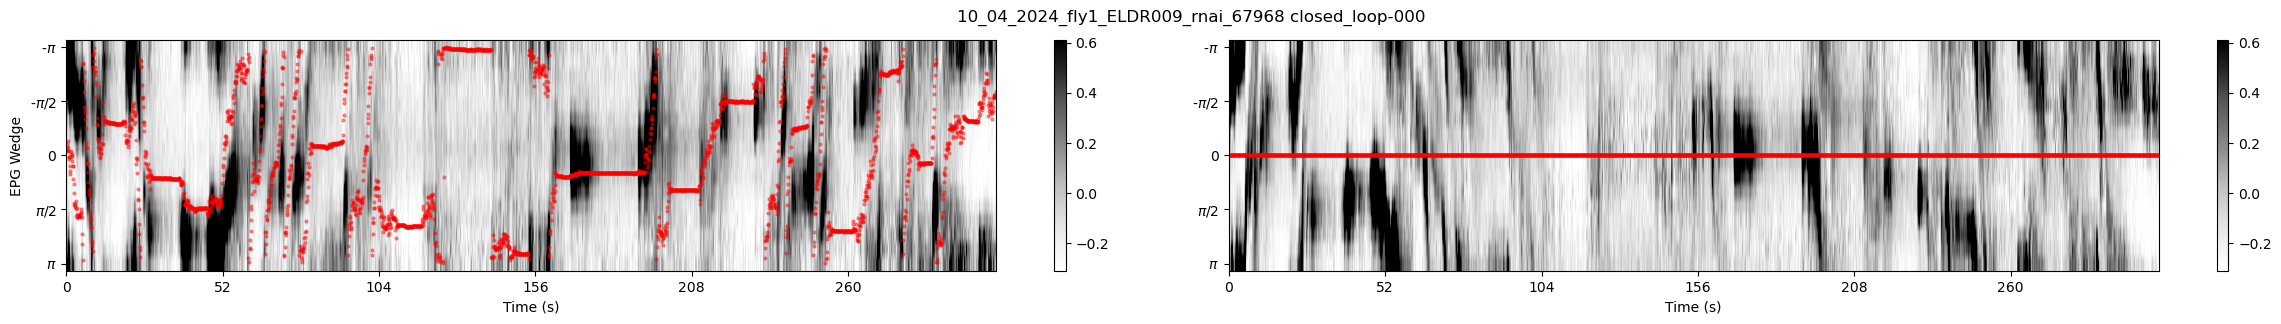

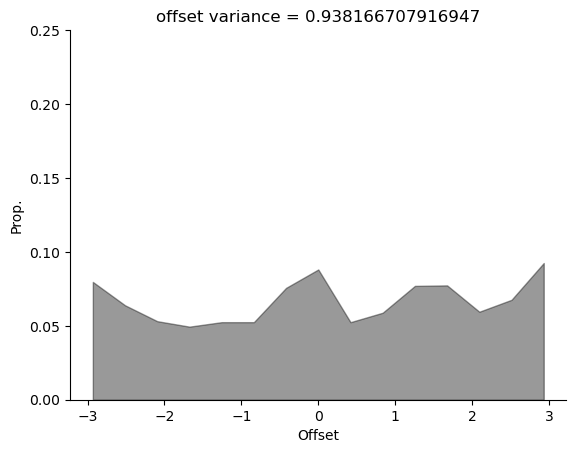

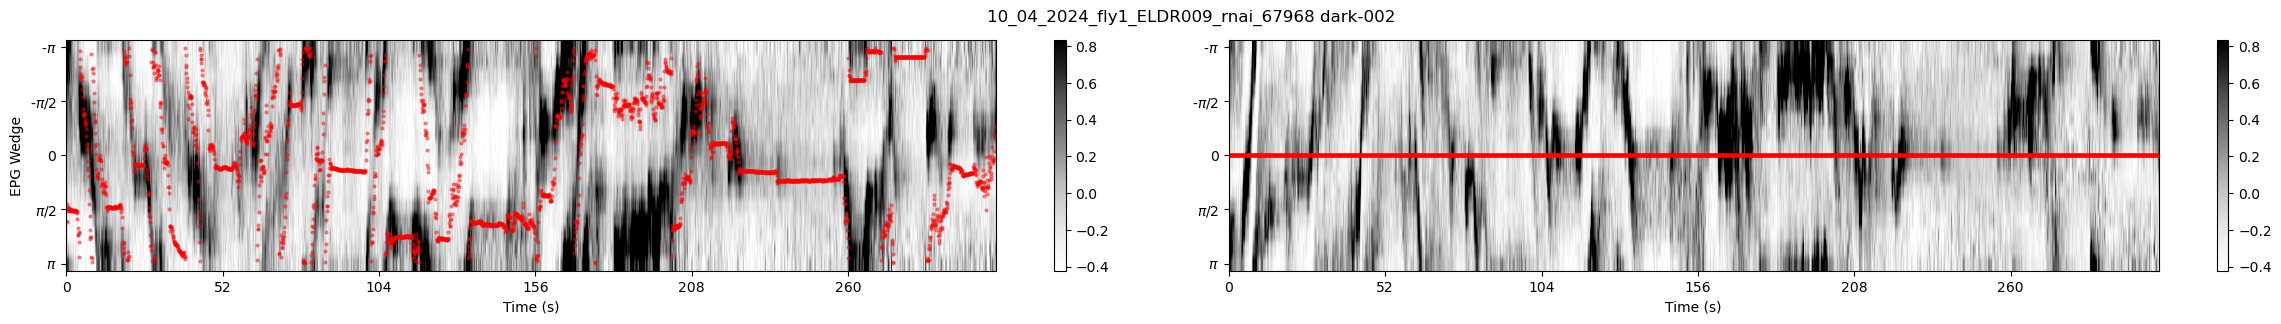

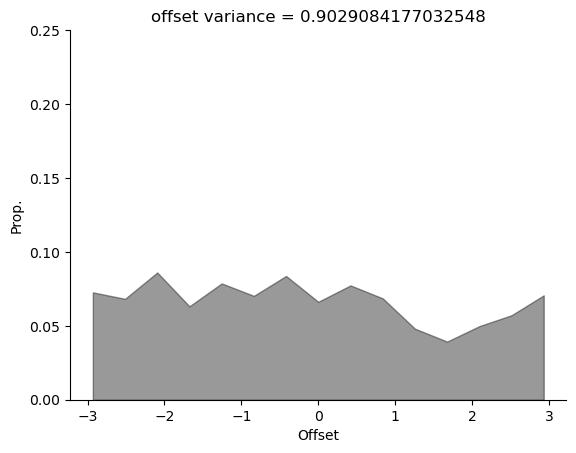

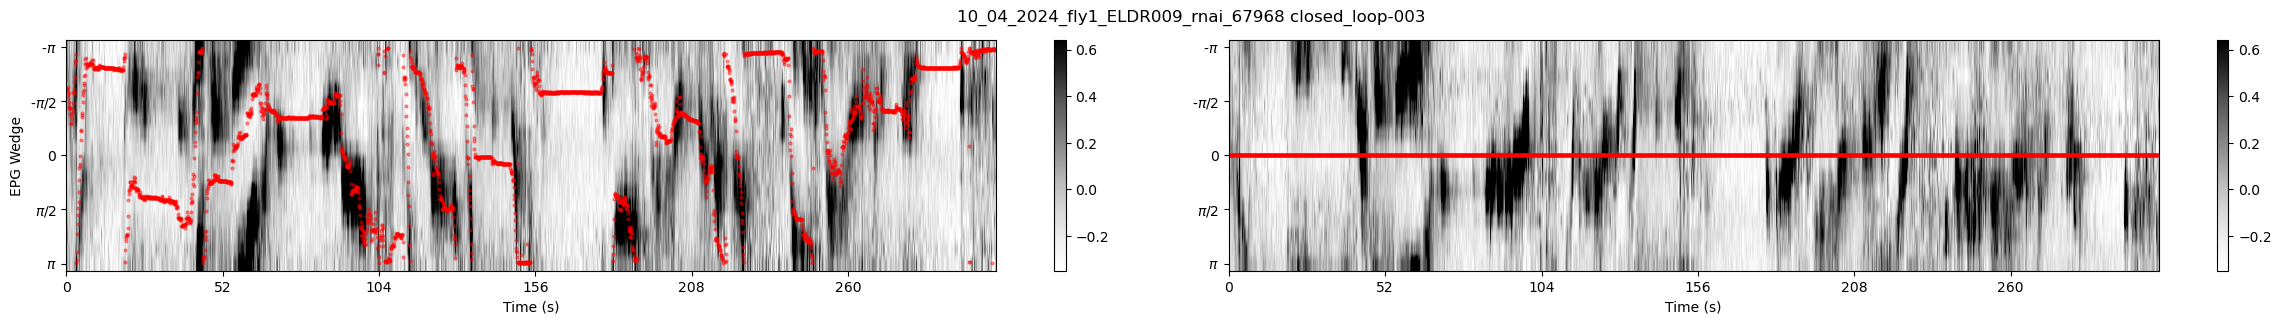

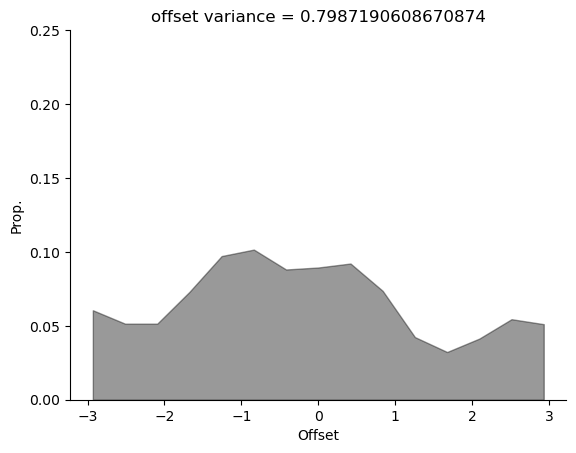

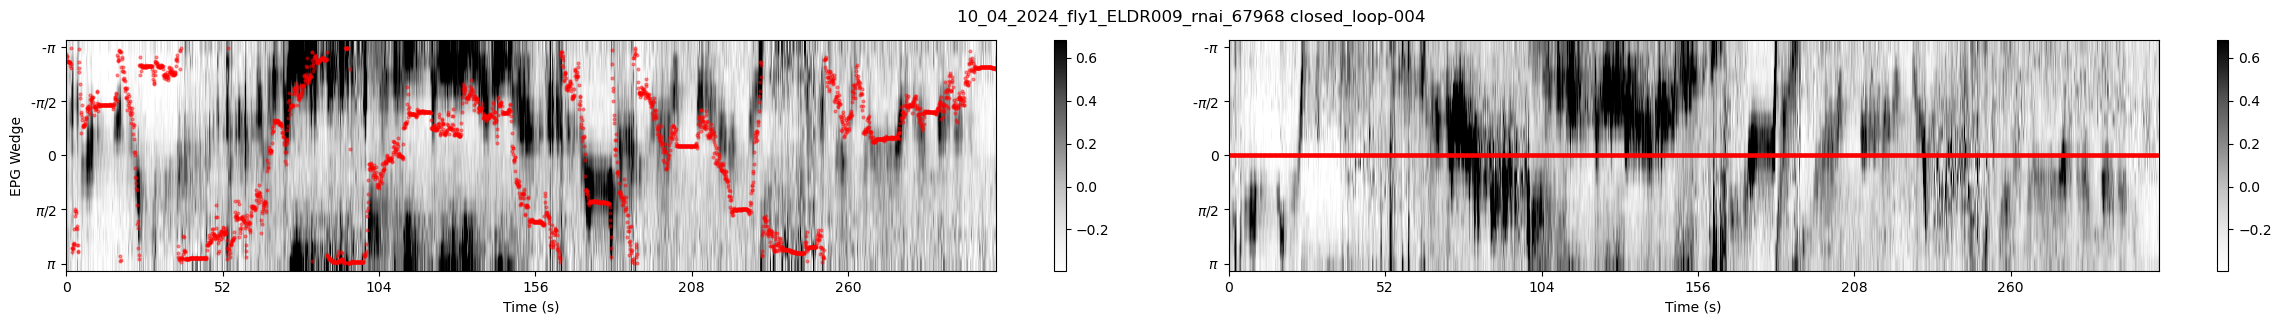

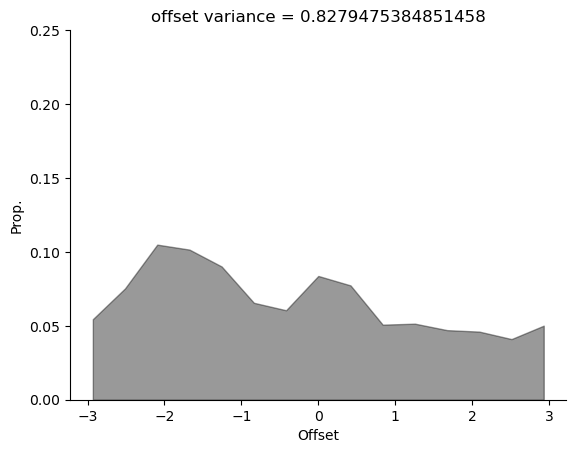

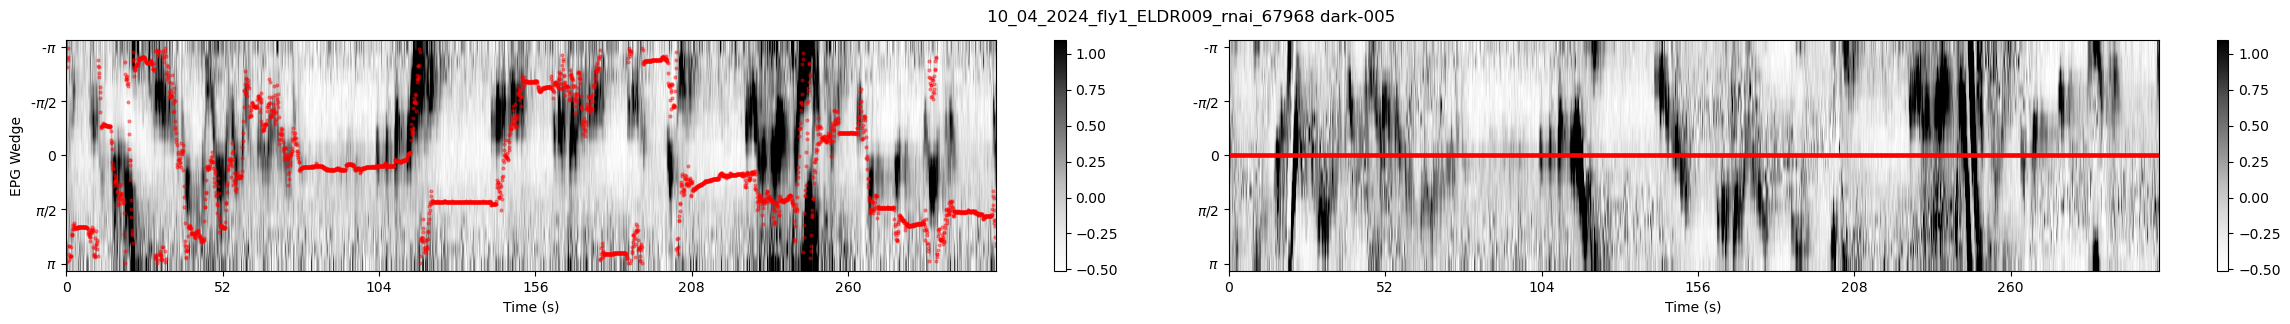

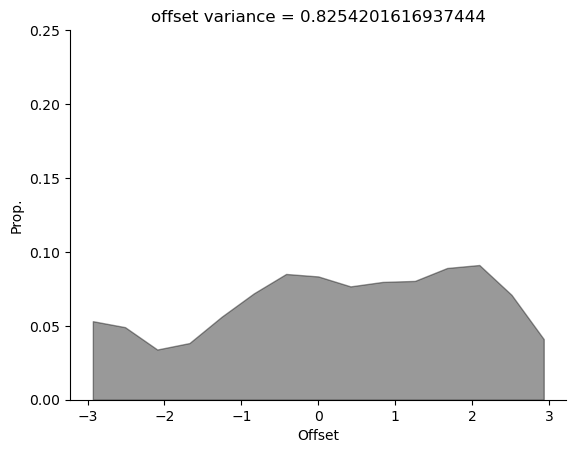

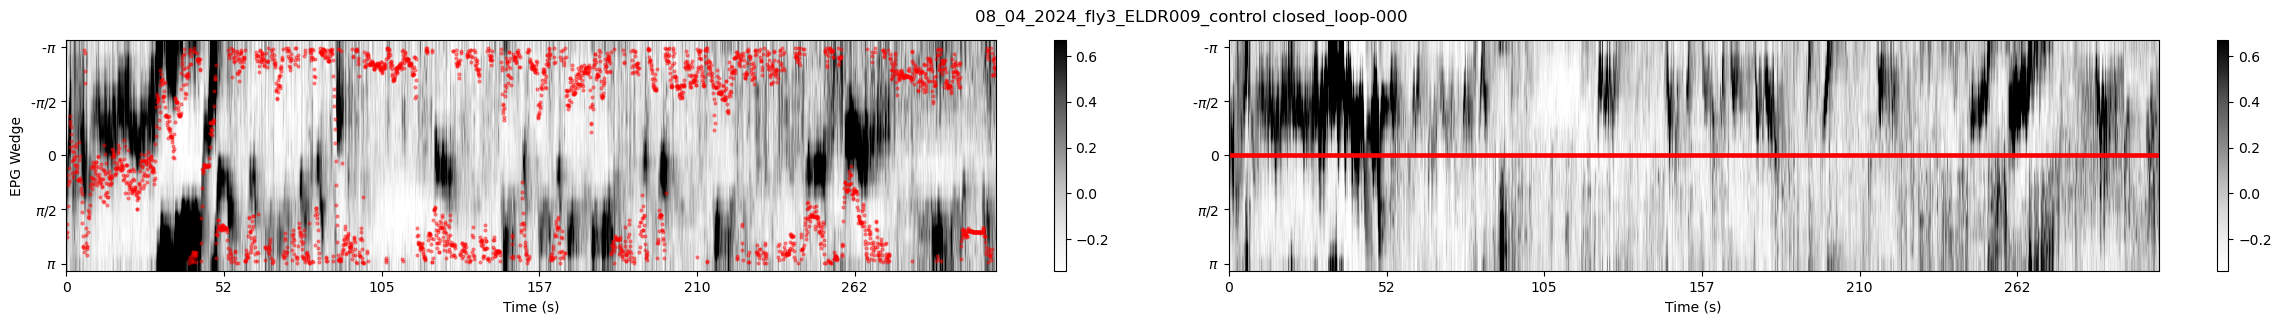

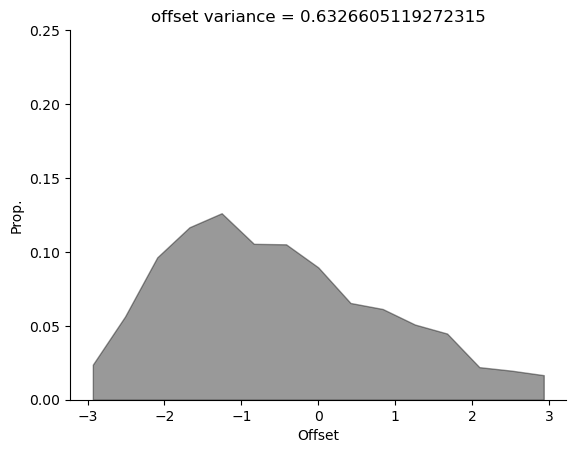

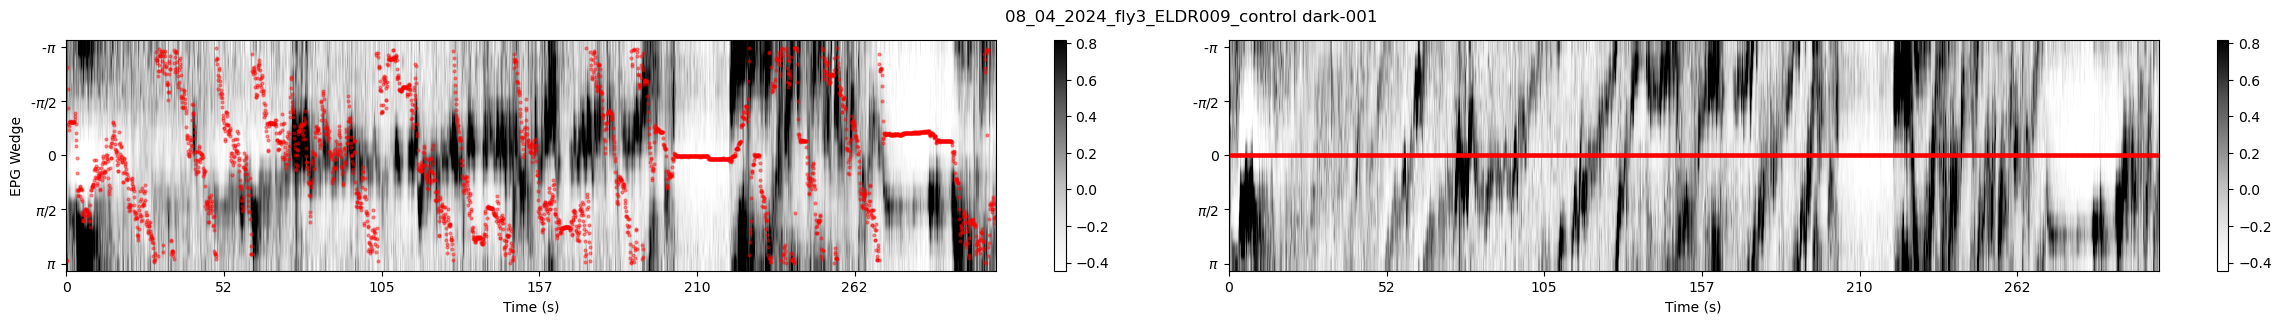

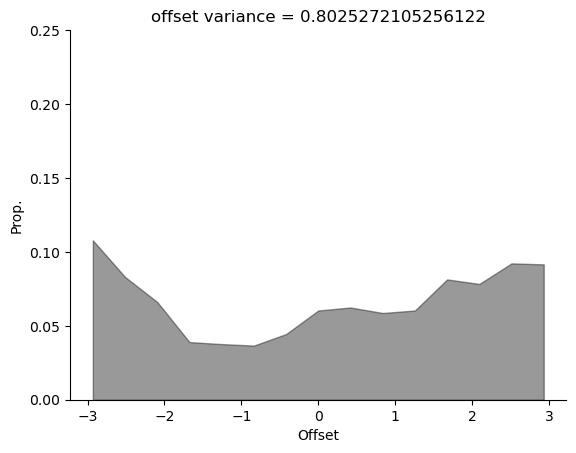

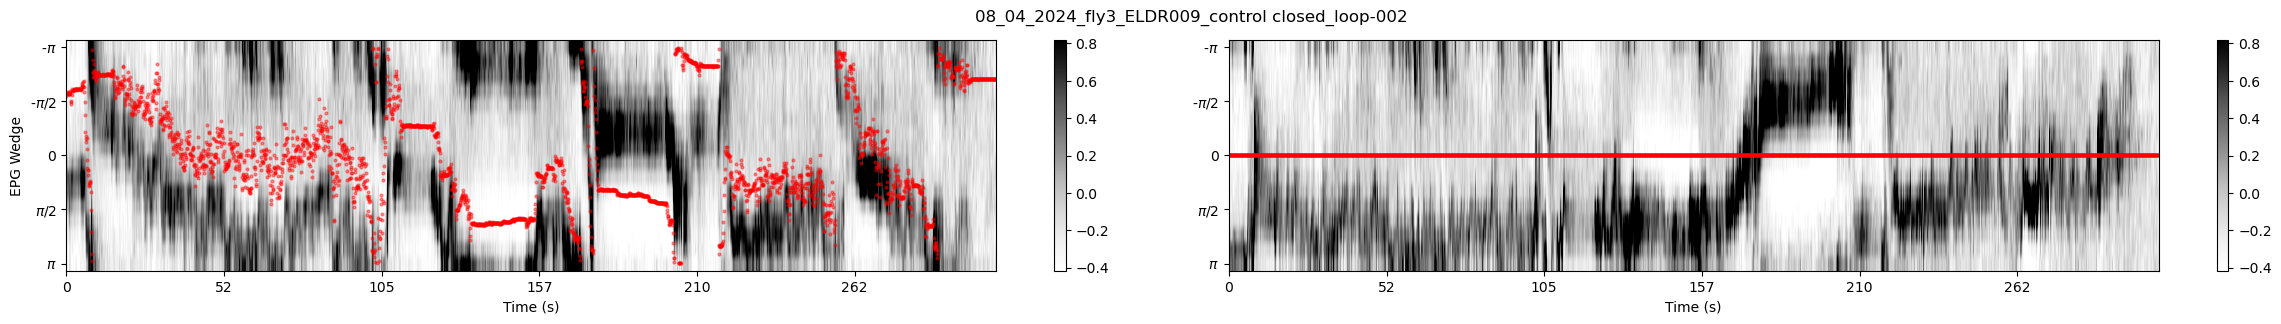

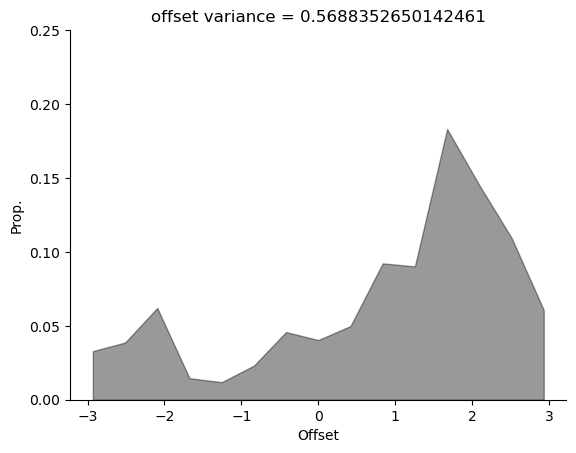

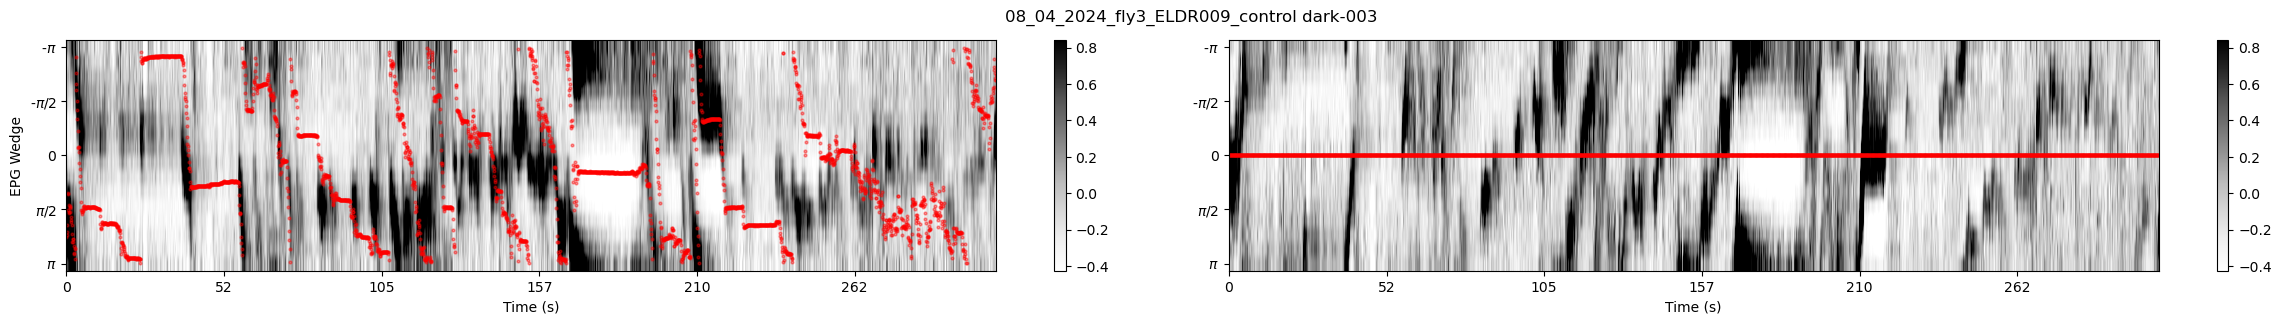

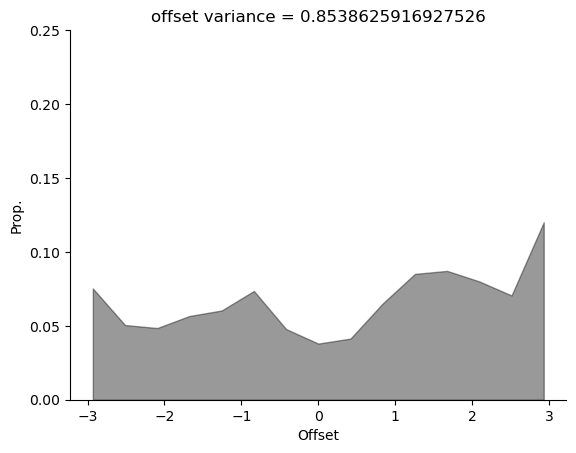

In [ ]:
for i, (_, row) in enumerate(sess_df.iterrows()):
    outdir = pathlib.PurePath( basedir / row['rnai_line '] / row['date'] /  row['fly'] / row['sess'] / 'preprocess.pkl')
    pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
    ts = get_ts(pp,coef=0)
    bins = np.arange(16)
    
    window = slice(0,10000)
    
    starting_offset = ts['offset_epg'][window][:50]
    so_x, so_y = st2p.utilities.pol2cart(np.ones_like(starting_offset), starting_offset)
    _, starting_offset_mu = st2p.utilities.cart2pol(so_x.mean(axis=0), so_y.mean(axis=0))
    _heading_centered = np.copy(ts['heading'][window]) + starting_offset_mu
    _, heading_centered = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones_like(_heading_centered), _heading_centered))
    

    
    # print(pp.voltage_recording_aligned['Time(ms)'])
    dt = pp.metadata['frame_period']*pp.metadata['layout']['frames_per_sequence']
    
    fig, ax=plt.subplots(1,2, figsize=[30,3])
    plt.subplots_adjust(wspace=0)
    h = ax[0].imshow(ts['y_epg'][-1,:,window]-1,aspect='auto',cmap='Greys', 
                 vmin=np.percentile(ts['y_epg'][-1,:,:]-1,5), 
                 vmax=np.percentile(ts['y_epg'][-1,:,:]-1,95))
    plt.colorbar(h)
    _heading = 15*(ts['heading'][window]+np.pi)/2/np.pi
    # _heading = 15*(heading_centered+np.pi)/2/np.pi
    
    x = np.arange(_heading.shape[0])
    
    t = np.arange(0,x[-1]*dt,dt)
    
    ax[0].scatter(x,_heading, color='red', s=4, alpha=.4)
    
    heading_bins, y_h_aligned, y_h_aligned_z = align_to_heading(ts)
    h = ax[1].imshow(y_h_aligned[-1,:,window]-1, aspect='auto',cmap='Greys', 
                 vmin=np.percentile(ts['y_epg'][-1,:,:]-1,5), 
                 vmax=np.percentile(ts['y_epg'][-1,:,:]-1,95))
    
    plt.colorbar(h)
    ax[1].scatter(x,7.5*np.ones_like(x), color='red', s=4, alpha=.4)
    
    ax[0].set_xticks(x[::500],labels=[int(_t) for _t in t[::500]])
    ax[1].set_xticks(x[::500],labels=[int(_t) for _t in t[::500]])
    for a in range(2):
        ax[a].set_yticks([r/2/np.pi*15 for r in (0,  np.pi/2,  np.pi,  6*np.pi/4,  2*np.pi)], 
                                                 labels = [r'-$\pi$',  r'-$\pi$/2',  '0',  r'$\pi$/2',  r'$\pi$'])
    ax[0].set_ylabel('EPG Wedge')
    ax[0].set_xlabel('Time (s)')
    ax[1].set_xlabel('Time (s)')
    
    # ax[1].hist(ts['offset_epg'],bins = np.linspace(-np.pi,np.pi, num=17), density=True)
    fig.suptitle(f"{row['fly_id']} {row['sess']}")
    fig.savefig(eg_folder / f"{row['fly_id']}_{row['sess']}_heading_centered.pdf")
#     add shifted data and histogram


    fig, ax = plt.subplots()
    edges = np.linspace(-np.pi,np.pi,num=16)
    centers = (edges[:-1]+edges[1:])/2
    hist, _ = np.histogram(ts['offset_epg'], bins = np.linspace(-np.pi,np.pi,num=16))
    ax.fill_between(centers, hist/hist.sum(), alpha=.4, color='black')
    ax.set_ylim([0,.25])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Offset')
    ax.set_ylabel('Prop.')
    offset_var = sp.stats.circvar(ts['offset_epg'])
    ax.set_title(f"offset variance = {offset_var}")
    fig.savefig(eg_folder / f"{row['fly_id']}_{row['sess']}_offset_histogram.pdf")


In [57]:
print()